<a href="https://colab.research.google.com/github/VenkateshDas/legal_text_retrieval_coliee/blob/master/COLIEE_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
!nvidia-smi

Wed Dec  2 10:08:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Install Huggingface Transforms library from which the pretrained model can be used. 

!pip install transformers

     |████████████████████████████████| 1.4MB 16.7MB/s 
     |████████████████████████████████| 890kB 53.5MB/s 
     |████████████████████████████████| 2.9MB 52.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=37a86389120f5ef63b96e2ecc5045758ddb5acc40136a1843abeecdd2ecf43a2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
#For one hot encoding the labels that will be used in the classification. 
from sklearn import preprocessing
#Splitting the Dataset into train and test
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Data analysis, creation and manipulation libraries 
import pandas as pd
#scientific library 
import numpy as np
import re

#tensorflow library for Deep learning (here)
import tensorflow as tf

#importing the pretrained models. 
from transformers import (TFBertForSequenceClassification, 
                          BertTokenizer)
from transformers import TFTrainer, TFTrainingArguments
from transformers import DistilBertTokenizerFast , TFDistilBertForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification , TFTrainer, TFTrainingArguments

import pickle
import time 
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score 

from sklearn.utils import class_weight

### Create Dataset

In [4]:
# Read the CSV dataset 
path_to_dataset ='/content/drive/My Drive/COLIEE Retrieval /COLIEE Dry Run Data /preprocessed_data/bert_data/'
train_classification_data = pd.read_csv(path_to_dataset+'top10_similar_up_and_downsampled_classification_dataset.csv',index_col=0)
test_classification_data = pd.read_csv(path_to_dataset+'classification_test_dataset.csv',index_col=0)

In [ ]:
# 595 times Label 1 oversampled
train_classification_data.shape

(18000, 5)

In [ ]:
train_classification_data.head()

,Serial_Num,ID,Sequence,Article_number,Label
0,1,H21-1-1,Acceptance made by a minor that received an o...,5,1
1,2,H21-1-2,"If a minor, after getting permission for carr...",6,1
2,3,H21-1-3,The purchase of daily household items may not...,9,1
3,4,H21-1-4,"If a person under curatorship performs, witho...",13,1
4,4,H21-1-4,"If a person under curatorship performs, witho...",120,1


In [ ]:
train_classification_data.tail()

,Serial_Num,ID,Sequence,Article_number,Label
539283,695,H24-30-3,In cases where A claims purchase money of mov...,689,0
539219,695,H24-30-3,In cases where A claims purchase money of mov...,632,0
539111,695,H24-30-3,In cases where A claims purchase money of mov...,537,0
539112,695,H24-30-3,In cases where A claims purchase money of mov...,538,0
539114,695,H24-30-3,In cases where A claims purchase money of mov...,539_2,0


In [ ]:
test_classification_data

,ID,Sequence,Article_number,Label
0,R01-1-A,Acceptance made by a minor that received an o...,1,0
1,R01-1-A,Acceptance made by a minor that received an o...,2,0
2,R01-1-A,Acceptance made by a minor that received an o...,3,0
3,R01-1-A,Acceptance made by a minor that received an o...,3_2,0
4,R01-1-A,Acceptance made by a minor that received an o...,4,0
...,...,...,...,...
86907,R01-37-U,"In cases where it is assumed, due to the natu...",721,0
86908,R01-37-U,"In cases where it is assumed, due to the natu...",722,0
86909,R01-37-U,"In cases where it is assumed, due to the natu...",723,0
86910,R01-37-U,"In cases where it is assumed, due to the natu...",724,0


In [5]:
#Initialising the tokenizer that will split the sequence into Byte-Pair Encoding. Subword embeddings that were used while training the DistilBert model. 

distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [6]:
def create_distilbert_tokenised_data(data,data_labels,path_to_save):

    start = time.time()

    train_encodings = distilbert_tokenizer(data, truncation=True, padding=True) # DistilBert
    
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        data_labels
    ))
    #https://www.tensorflow.org/api_docs/python/tf/data/experimental/load
    tf.data.experimental.save(train_dataset, path_to_save)

    del(train_encodings)
    del(train_dataset)
    end = time.time()

    total = end - start
    print('Time taken for encoding and saving : {}'.format(total/60))

    train_dataset = tf.data.experimental.load(path_to_save,
    ({'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, tf.TensorSpec(shape=(), dtype=tf.int32, name=None)))


    return train_dataset

In [7]:
#Split the dataset into a training and testing modules that will be used for training and evaluation. 

def create_classification_dataset(path_to_dataset,train_classification_data,test_classification_data):
    
    '''
    Train , Val and test dataset with DistilBert Encodings.
    '''
    train_dataset_path = path_to_dataset+'top10_similar_up_and_downsampled_train_dataset'
    validation_dataset_path = path_to_dataset+'top10_similar_up_and_downsampled_validation_dataset'
    test_dataset_path = path_to_dataset+'test_dataset'

    if os.path.exists(train_dataset_path) and os.path.exists(validation_dataset_path):

        train_dataset = tf.data.experimental.load(train_dataset_path,
        ({'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, tf.TensorSpec(shape=(), dtype=tf.int32, name=None)))
        
        print("Train Dataset loaded")

        validation_dataset = tf.data.experimental.load(validation_dataset_path,
        ({'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, tf.TensorSpec(shape=(), dtype=tf.int32, name=None)))

        print("Validation Dataset loaded")

    else : 
        
        X = list(train_classification_data['Sequence'])
        y = list(train_classification_data['Label'])


        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=13)
        print("Train dataset shape: {0} \nValidation dataset shape: {1}".format(len(X_train), len(X_val)))

        #Custom Tf.data.Dataset object creation according to the input data. 
        train_dataset = create_distilbert_tokenised_data(X_train,y_train,train_dataset_path)

        # train_dataset_1 = create_distilbert_tokenised_data(X_train[:100000],y_train[:100000],path_to_dataset+'595_train_dataset_1')
        # train_dataset_2 = create_distilbert_tokenised_data(X_train[100000:200000],y_train[100000:200000],path_to_dataset+'595_train_dataset_2')
        # train_dataset_3 = create_distilbert_tokenised_data(X_train[200000:300000],y_train[200000:300000],path_to_dataset+'595_train_dataset_3')
        # train_dataset_4 = create_distilbert_tokenised_data(X_train[300000:400000],y_train[300000:400000],path_to_dataset+'595_train_dataset_4')
        # train_dataset_5 = create_distilbert_tokenised_data(X_train[400000:500000],y_train[400000:500000],path_to_dataset+'595_train_dataset_5')
        # train_dataset_6 = create_distilbert_tokenised_data(X_train[500000:600000],y_train[500000:600000],path_to_dataset+'595_train_dataset_6')
        # train_dataset_7 = create_distilbert_tokenised_data(X_train[600000:700000],y_train[600000:700000],path_to_dataset+'595_train_dataset_7')
        # train_dataset_8 = create_distilbert_tokenised_data(X_train[700000:800000],y_train[700000:800000],path_to_dataset+'595_train_dataset_8')
        # train_dataset_9 = create_distilbert_tokenised_data(X_train[800000:900000],y_train[800000:900000],path_to_dataset+'595_train_dataset_9')
        # train_dataset_10 = create_distilbert_tokenised_data(X_train[900000:],y_train[900000:],path_to_dataset+'595_train_dataset_10')

        # train_dataset = train_dataset_1.concatenate(train_dataset_2)
        # train_dataset = train_dataset.concatenate(train_dataset_3)
        # train_dataset = train_dataset.concatenate(train_dataset_4)
        # train_dataset = train_dataset.concatenate(train_dataset_5)
        # train_dataset = train_dataset.concatenate(train_dataset_6)
        # train_dataset = train_dataset.concatenate(train_dataset_7)
        # train_dataset = train_dataset.concatenate(train_dataset_8)
        # train_dataset = train_dataset.concatenate(train_dataset_9)
        # train_dataset = train_dataset.concatenate(train_dataset_10)


        tf.data.experimental.save(train_dataset, train_dataset_path)
        train_dataset = tf.data.experimental.load(train_dataset_path,
            ({'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, tf.TensorSpec(shape=(), dtype=tf.int32, name=None)))

        print("Train Dataset created and saved .")

        validation_dataset = create_distilbert_tokenised_data(X_val,y_val,validation_dataset_path)

        print("Validation Dataset created and saved .")

    if os.path.exists(path_to_dataset+'test_dataset') == True:

        test_dataset = tf.data.experimental.load(test_dataset_path,
        ({'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, tf.TensorSpec(shape=(), dtype=tf.int32, name=None)))

        print("Test Dataset loaded")
    
    else : 

        X_test = list(test_classification_data['Sequence'])
        y_test = list(test_classification_data['Label'])
        start = time.time()

        test_encodings = distilbert_tokenizer(X_test, truncation=True, padding=True)
        
        test_dataset = tf.data.Dataset.from_tensor_slices((
            dict(test_encodings),
            y_test))
        #https://www.tensorflow.org/api_docs/python/tf/data/experimental/load
        tf.data.experimental.save(test_dataset, test_dataset_path)

        del(test_encodings)
        del(test_dataset)
        end = time.time()

        total = end - start
        print('Time taken for encoding and saving : {}'.format(total/60))

        test_dataset = tf.data.experimental.load(test_dataset_path,
        ({'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, tf.TensorSpec(shape=(), dtype=tf.int32, name=None)))

        print("Test Dataset created and saved .")


    return train_dataset , validation_dataset , test_dataset



In [8]:
path_to_tfds_bert_data = '/content/drive/My Drive/COLIEE Retrieval /tfds_bert_data/'
train_dataset , validation_dataset , test_dataset = create_classification_dataset(path_to_tfds_bert_data,train_classification_data,test_classification_data)

Train Dataset loaded
Validation Dataset loaded
Test Dataset loaded


This way the whole dataset can be encoded / tokenised efficiently without clogging up the memory. 

In [ ]:
#calculate class weights

X = list(train_classification_data['Sequence'])
y = list(train_classification_data['Label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=13)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights = dict(enumerate(class_weights))


In [ ]:
class_weights

{0: 1.004339739615623, 1: 0.9956976029502151}

### Finetune model

In [ ]:
# We classify two labels in this example. In case of multiclass classification, adjust num_labels value

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                              num_labels=2)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_209']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
# intialising the optimisers , loss function and evaluation metric
#model.compute_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
 
# Calling the training function for fine tuniong the pretrained model 
model.fit(train_dataset.shuffle(100).batch(8), #Batch size 
          epochs=4,
          batch_size=8,
          validation_data=validation_dataset.shuffle(100).batch(8),use_multiprocessing = True,workers = 4 )#, class_weight = class_weights)

Model architecture for TFDistilBertForSequenceClassification

    class TFDistilBertForSequenceClassification(TFDistilBertPreTrainedModel, TFSequenceClassificationLoss):
            def __init__(self, config, *inputs, **kwargs):
                super().__init__(config, *inputs, **kwargs)
                self.num_labels = config.num_labels

                self.distilbert = TFDistilBertMainLayer(config, name="distilbert")
                self.pre_classifier = tf.keras.layers.Dense(
                    config.dim,
                    kernel_initializer=get_initializer(config.initializer_range),
                    activation="relu",
                    name="pre_classifier",
                )
                self.classifier = tf.keras.layers.Dense(
                    config.num_labels, kernel_initializer=get_initializer(config.initializer_range), name="classifier"
                )
                self.dropout = tf.keras.layers.Dropout(config.seq_classif_dropout)
                @add_start_docstrings_to_callable(DISTILBERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
                @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint="distilbert-base-uncased",
        output_type=TFSequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
                )
        def call(
        self,
        inputs=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        labels=None,
        training=False,
        ):
        r"""
        labels (:obj:`tf.Tensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels - 1]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.distilbert.return_dict
        if isinstance(inputs, (tuple, list)):
            labels = inputs[7] if len(inputs) > 7 else labels
            if len(inputs) > 7:
                inputs = inputs[:7]
        elif isinstance(inputs, (dict, BatchEncoding)):
            labels = inputs.pop("labels", labels)

        distilbert_output = self.distilbert(
            inputs,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            training=training,
        )

        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output, training=training)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, dim)

        loss = None if labels is None else self.compute_loss(labels, logits)

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return TFSequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )


In [ ]:
# Model architecture 
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Saving the model after the training. 

FOLDERNAME = "top_10_similar_up_and_downsample"

model.save_pretrained("/content/drive/My Drive/COLIEE Retrieval /bert_model/"+FOLDERNAME)

In [ ]:
# loading the fintuned model 

loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/content/drive/My Drive/COLIEE Retrieval /bert_model/"+FOLDERNAME)

Some layers from the model checkpoint at /content/drive/My Drive/COLIEE Retrieval /bert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/My Drive/COLIEE Retrieval /bert_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loaded_model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  1538      
_________________________________________________________________
dropout_59 (Dropout)         multiple                  0         
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


### Finetuned model Evaluation

In [ ]:
#Evaluation 

# Tokeinising the test dataset (Due to the memory error the test set was reduced to 100 instances . But this issue has to be resolved)
# test_enc = distilbert_tokenizer(X_test, truncation=True, padding=True,return_tensors='tf')

# After tokenising the test dataset, it is fed into the loaded fintuned model for calculating the sentence embeddings and fed into the classifier.  Logits value are calculated in the classifier layer. 
# tf_out = loaded_model(test_enc)
tf_out = loaded_model.predict(test_dataset.shuffle(100).batch(8))

#The final output of the finetuned model is not a probability value since the last layer is not a softmax or a sigmoid layer. So the final output is fed into a Softmax layer to convert it into a probability value. 
tf_predictions = tf.nn.softmax(tf_out[0], axis=-1)

#The label with higher probability is chosen as the predicted probability. 
predicted_label = tf.argmax(tf_predictions, axis=1)

#Covnert the predicted value from a tensor to a array for evaluation. 
predicted_label_array=predicted_label.numpy()


In [ ]:
tf_out[0].shape

(86912, 2)

In [ ]:
tf_predictions.shape

TensorShape([86912, 2])

In [ ]:
# print(predicted_label_array)
print(predicted_label_array.shape)

(86912,)


In [ ]:
predicted_label_array[1]

0

In [ ]:
y_val_list = list(validation_dataset.as_numpy_iterator())
y_val = [y[-1] for y in y_val_list]

In [ ]:
len(y_val)

62842

In [ ]:
y_test = list(test_classification_data['Label'])
len(y_test)

86912

In [ ]:
c = 0
for i in range(len(predicted_label_array)):
    if predicted_label_array[i] == 1:
        c = c + 1

In [ ]:
print(c)

1790


In [ ]:
#Evaluation of the model's performance using confusion matrix. 

print(classification_report(y_test, predicted_label_array))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     86774
           1       0.00      0.01      0.00       138

    accuracy                           0.98     86912
   macro avg       0.50      0.49      0.49     86912
weighted avg       1.00      0.98      0.99     86912



In [ ]:
cm = classification_report(y_test, predicted_label_array)

In [ ]:
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix ')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


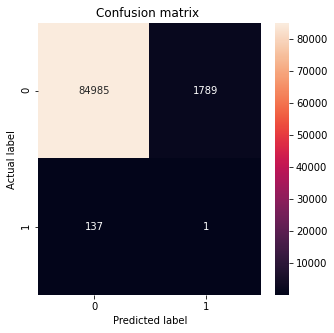

In [ ]:
plot_cm(y_test, predicted_label_array)

In [ ]:
"{:0.2f}".format(roc_auc_score(y_test, predicted_label_array)*100.0)

'49.33'

In [ ]:
preds = tf_predictions.numpy()

In [ ]:
p0 = preds[:,0]
p1 = preds[:,1]

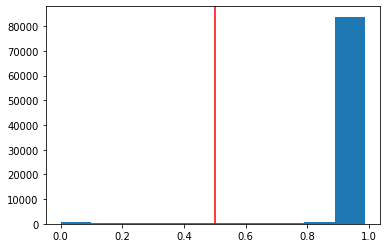

In [ ]:
plt.hist(p0)
_ = plt.axvline(x=0.5, color='Red')

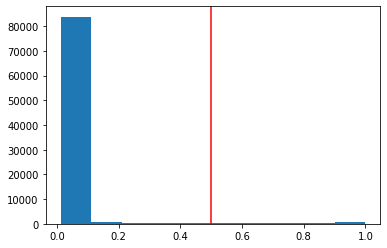

In [ ]:
plt.hist(p1)
_ = plt.axvline(x=0.5, color='Red')

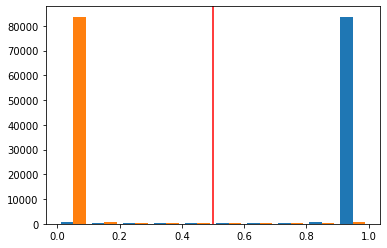

In [ ]:
plt.hist(preds)
_ = plt.axvline(x=0.5, color='Red')

#### Trec Eval file creation


In [ ]:
def create_trec_eval_file(classification_test_dataframe,predicted_label_array,result_file_path):
    test_id_list = []
    article_number_list = []
    result = []

    for prediction_index in range(len(predicted_label_array)):

        if predicted_label_array[prediction_index] == 1:
            predicted_label = predicted_label_array[prediction_index]
            test_id = classification_test_dataframe['ID'].iloc[prediction_index]
            article_number = classification_test_dataframe['Article_number'].iloc[prediction_index]

            test_id_list.append(test_id)
            article_number_list.append(article_number)
    
    test_query_result_dict = {}

    # for item in range(len(test_id_list)):
    #     if test_id_list[item] in test_query_result_dict.keys():
    #         test_query_result_dict[test_id_list[item]] = test_query_result_dict[test_id_list[item]] + 1
    #     else: 
    #         test_query_result_dict[test_id_list[item]] = 1
    
    for item in range(len(test_id_list)):
        article_num = str(article_number_list[item])
        article_num = re.sub('_','-',article_num)
        result.append(test_id_list[item]+" "+"Q0"+" "+article_num+" "+"1"+" "+"1"+" "+"OvGU")

    f= open(result_file_path,"w+")
    for i in range(len(result)):
        f.write(result[i]+"\n")
    f.close()

    return test_id_list,article_number_list #, test_query_result_dict

In [ ]:
result_file_path = "/content/drive/My Drive/COLIEE Retrieval /bert_result/top_10_similar_up_and_downsample_test_result.txt"
test_id_list,article_number_list = create_trec_eval_file(test_classification_data,predicted_label_array,result_file_path)

In [ ]:
predicted_label_array[:100]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
np.array(y_test[:100])

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### References: 

1. https://medium.com/@kaijuneer/fine-tuning-tensorflow-bert-model-for-sentiment-analysis-1119fd6bef49
2. https://huggingface.co/transformers/custom_datasets.html

manual 
https://huggingface.co/transformers/preprocessing.html
https://huggingface.co/transformers/master/custom_datasets.html

blogs

https://towardsdatascience.com/working-with-hugging-face-transformers-and-tf-2-0-89bf35e3555a

http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

https://androidkt.com/state-of-the-art-text-classification-using-bert-in-ten-lines-of-tensorflow-2-0/

https://www.tensorflow.org/official_models/fine_tuning_bert




### Questions

1. How effective Classification task will be in terms of retrieval on an english dataset which is oversampled?